# Helping Hotels in times of flexible bookings

As the pandemic has changed the tourism industry customers are more and more used to flexibility options and cancellations when it comes to hotel bookings. Hotels are therefore offering their customers more options when it comes to changing and cancelling an existing booking. However, this imposes cost to a hotel business, as rooms are reserved for a long time and then might be cancelled shortly in advance. This short time is often not enough to find a new, paying customer for the hotel room. 

Therefore hotels might use a concept that is already prevailent in airlines: Overbooking the rooms they actually have. By accepting more bookings than a hotel has rooms, it can make sure to be closer to full capacity utilization. However, this imposes the risk of not having rooms available and having to reject customers that have a reserved room. This would be a very bad situation. Therefore it can be very beneficial to build a Machine Learning model that successfully predicts whether a customer is likely to cancel their booking. That is the goal of this work. 

### Select a performance measure


### Check the assumptions

## 0. Imports & Data Access

In [6]:
import matplotlib.pyplot as plt
import missingno
import pandas as pd
import seaborn as sns
import os
from datetime import timedelta

plt.style.use('seaborn')

In [40]:
exec_directory = os.getcwd()
main_directory = "Hotel-Booking-ML"
main_dir_path = exec_directory[:exec_directory.find(main_directory) + len(main_directory)]
raw_data_files_location = f"{main_dir_path}/data/raw"
df = pd.read_csv(f"{raw_data_files_location}/hotel_booking.csv")

As a first step we'll drop the columns 'reservation_status' and 'reservation_status_date' as they include information on our label. The value 'canceled' in 'reservation_status' indicates the same as 'is_canceled', this obviously information we don't need and shouldn't feed into the model.

In [41]:
df.drop(columns = ['reservation_status', 'reservation_status_date' ], inplace = True)

## 1. Data Exploration

In [37]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,booking_date_day_of_week,guests,stay_total_nights
count,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,...,119386.000000,103048.000000,6797.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000
mean,0.370395,104.014801,2016.156593,6.552435,27.165003,15.798553,0.927605,2.500310,1.856390,0.103890,...,0.221131,86.694841,189.266735,2.321227,101.833541,0.062520,0.571340,2.604401,1.968229,3.427914
std,0.482913,106.863286,0.707456,3.090659,13.605334,8.780783,0.998618,1.908289,0.579261,0.398561,...,0.652315,110.775127,131.655015,17.595011,50.534664,0.245295,0.792798,1.843078,0.722400,2.557444
min,0.000000,0.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,4.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,...,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000,1.000000,2.000000,2.000000
50%,0.000000,69.000000,2016.000000,7.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,...,0.000000,14.000000,179.000000,0.000000,94.590000,0.000000,0.000000,3.000000,2.000000,3.000000
75%,1.000000,160.000000,2017.000000,9.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,...,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000,4.000000,2.000000,4.000000
max,1.000000,737.000000,2017.000000,12.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,...,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000,6.000000,55.000000,69.000000


<AxesSubplot:>

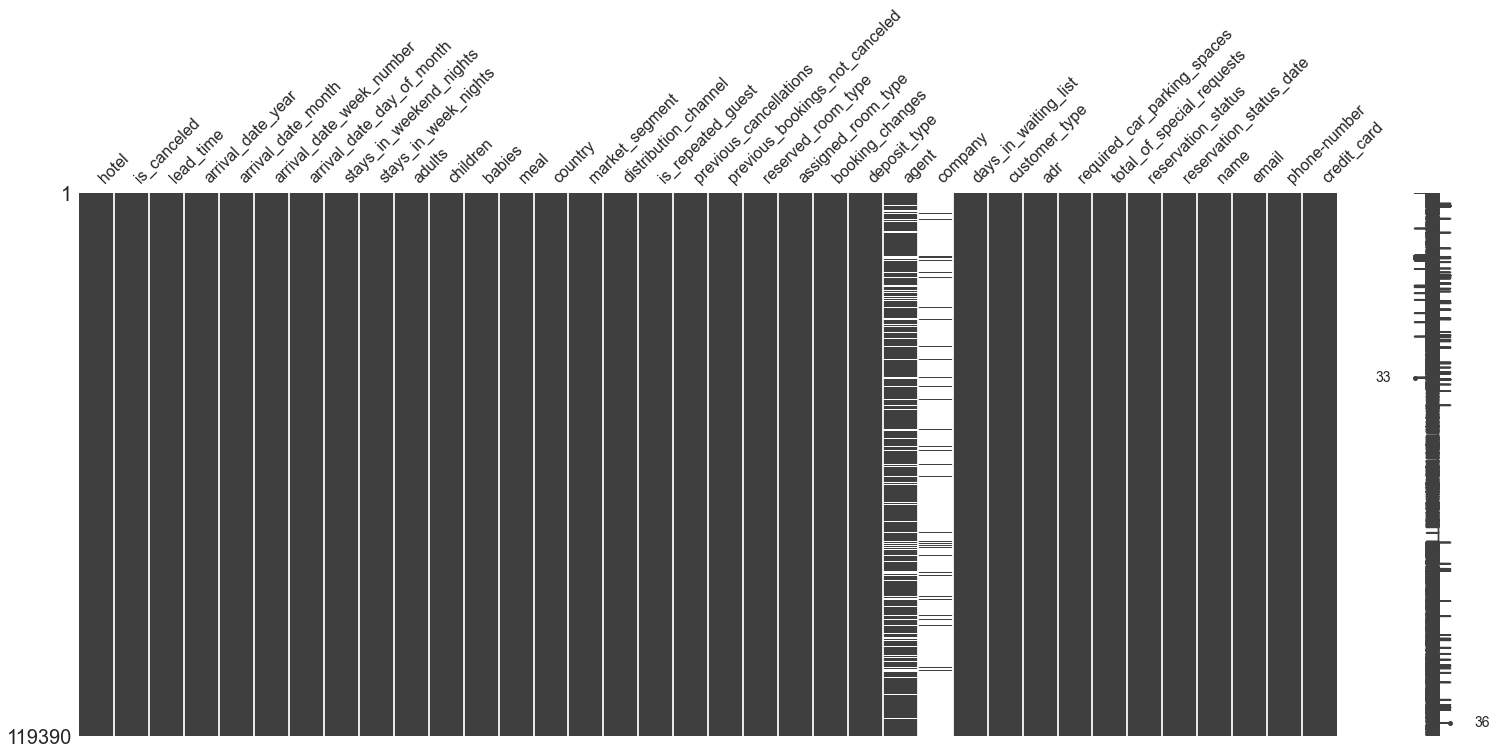

In [10]:
missingno.matrix(df)

#### Missing values

Luckily our dataset is complete for all features apart from agent and company. According to the data dictionary of the dataset these columns represent IDs of the agents and companies (in case of business travel) that made the bookings. Therefore it is likely that missing values do represent an information: a NA in 'company' indicates that the booking was not a business travel and a NA in 'agent' indicates that no agent was used for the booking, meaning that it was a direct booking.

Therefore we'll use OneHot encoding later on, to understand if there is a correlation between company, agent and our labels. 

# @Erik: Ist das hier relevant? Bei children dürfte es doch eigentlich keine NAs geben? (siehe oben)

In [13]:
df.dropna(subset=['children'], inplace=True)
df['children'] = df['children'].astype(int)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.00,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,Transient,96.14,0,0,Check-Out,2017-09-06,Claudia Johnson,Claudia.J@yahoo.com,403-092-5582,************8647
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,Transient,225.43,0,2,Check-Out,2017-09-07,Wesley Aguilar,WAguilar@xfinity.com,238-763-0612,************4333
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,Transient,157.71,0,4,Check-Out,2017-09-07,Mary Morales,Mary_Morales@hotmail.com,395-518-4100,************1821
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,Transient,104.40,0,0,Check-Out,2017-09-07,Caroline Conley MD,MD_Caroline@comcast.net,531-528-1017,************7860


#### Data transformation and aggregation. 

Before starting with the EDA we'll transform arrival and booking date to datetime format, calculate the number of total nights and retrieve the total number of guests.

In [128]:
# Getting arrival and booking dates right
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
                         'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df['arrival_date_month'] = df['arrival_date_month'].apply(lambda m: month_mapping[m])
df['arrival_date'] = pd.to_datetime(dict(year = df.arrival_date_year, 
                                         month = df.arrival_date_month, 
                                         day = df.arrival_date_day_of_month))
df['booking_date'] = df.apply(lambda r: r['arrival_date'] - timedelta(days=r['lead_time']), axis=1)
df['booking_date_day_of_week'] = df['booking_date'].dt.weekday

# Number of Guests
df['guests'] = df['adults'] + df['children'] + df['babies']

# Length of stay
df['stay_total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']


## 2. Exploratory Data Analysis

We firstly split the EDA for categorical and numerical features, as we'll perform different analysis methods. 

There are two exceptions here: 
- We'll see binary variables (with 0 and 1) as a numerical feature, as it can be analyzed with the methdos we use for the 'true' numerical features.
- The 'hotel' feature discribes whether the data is for a 'City Hotel' or a 'Resort Hotel', it will be analyzed in numerical features as well. This is because we want to identify if it is worth to split the data we have according to the hotel and build separate models for each of the hotels. 

In [131]:
categorical_features = [ 'meal', 'country', 'market_segment', 'distribution_channel', 
                         'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company', 
                         'customer_type']

df_num = df.drop(columns = categorical_features)
df_cat = df[categorical_features]

### 2.1 Numerical features
#### 2.1.1 Correlations

# @Erik: Wofür sind die correlations unter den feature variablen relevant? willst du multicollinearity entdecken?

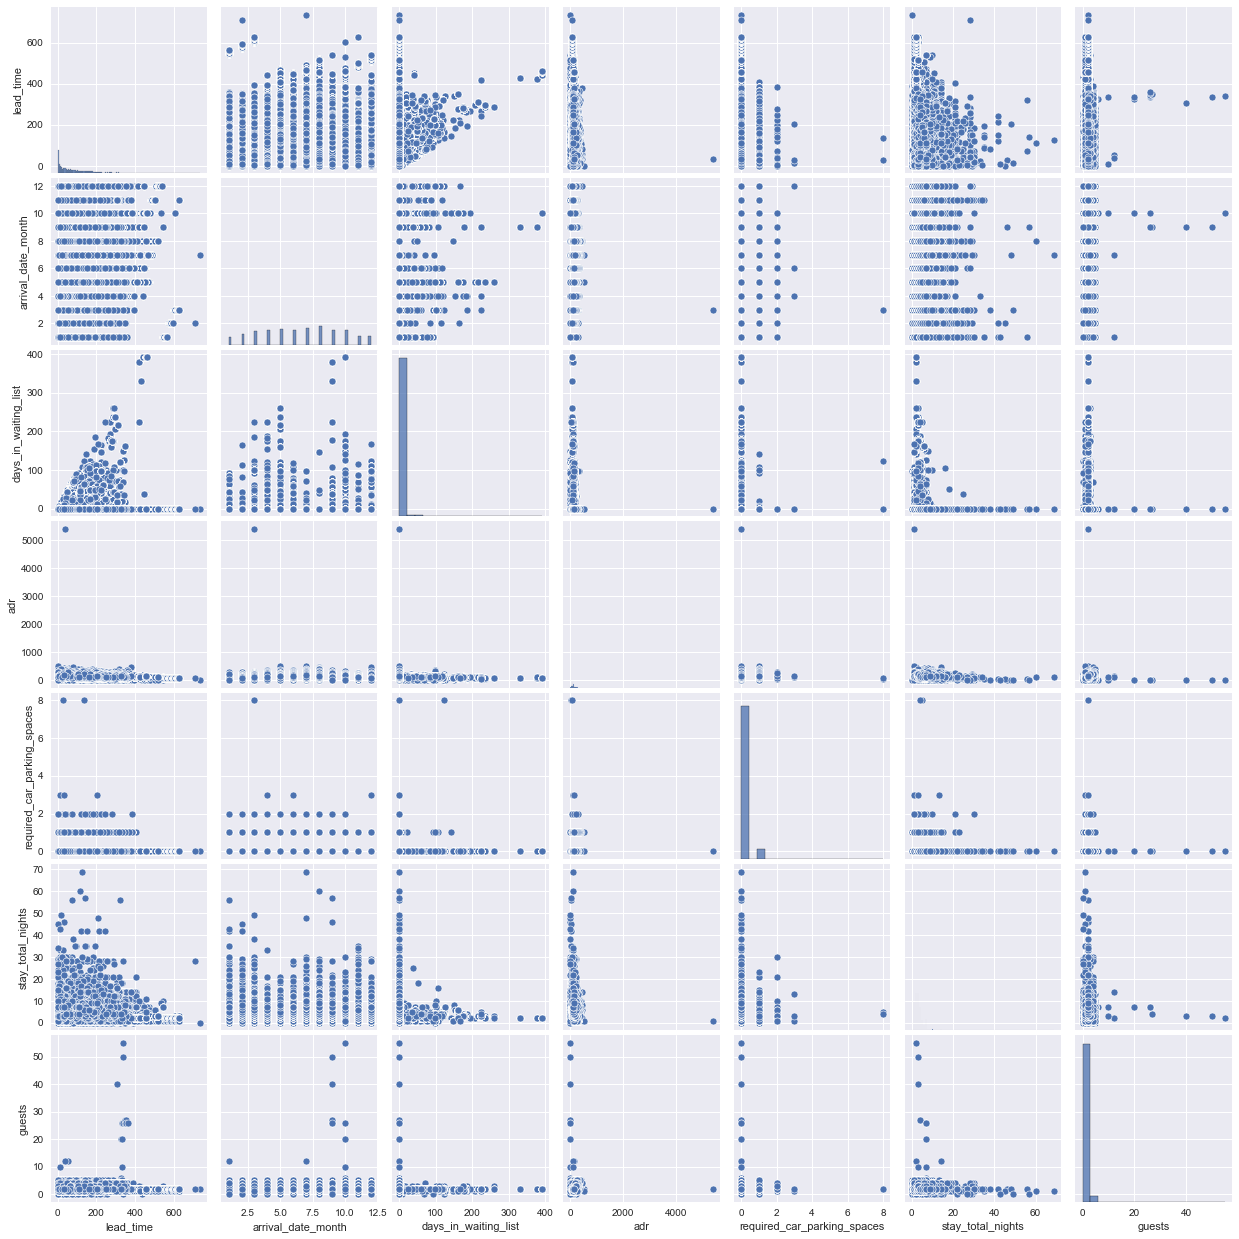

In [130]:
sns.pairplot(data=df_num[['lead_time', 'arrival_date_month','days_in_waiting_list', 'adr', 
                      'required_car_parking_spaces', 'stay_total_nights', 'guests']])
plt.show(sns)

# @Erik: würde das hier eher weg lassen, da wir die relevanten Correlations mit is_cancelled ja unten in dem bar chart haben, oder?

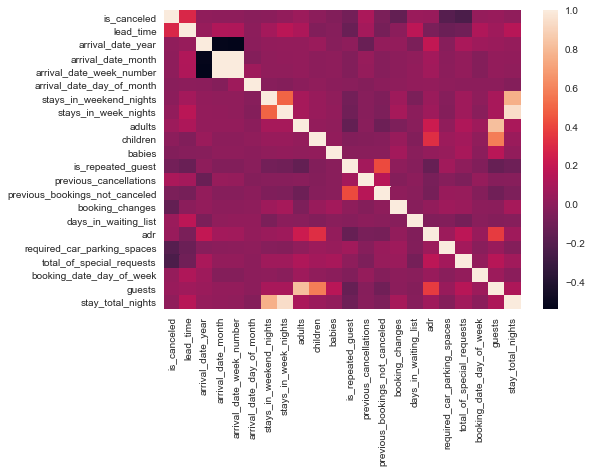

In [132]:
sns.heatmap(df_num.corr())
plt.show(sns)

Now, lets split the correlations for the resort and city hotel to find out if they differ substiantially. This will be interesting when deciding whether to build separate models or not. 

In [133]:
correlations_all = df_num.corr()['is_canceled'].sort_values(ascending=False)
correlations_city = df_num[df_num['hotel'] == 'City Hotel'].corr()['is_canceled']
correlations_resort = df_num[df_num['hotel'] == 'Resort Hotel'].corr()['is_canceled']
correlations_df = correlations_all.to_frame().rename({'is_canceled': "All"}, axis=1)
correlations_df = correlations_df.join(correlations_city).rename({'is_canceled': "City"}, axis=1)
correlations_df = correlations_df.join(correlations_resort).rename({'is_canceled': "Resort"}, axis=1)
correlations_df

,All,City,Resort
is_canceled,1.000000,1.000000,1.000000
lead_time,0.293123,0.309242,0.229444
previous_cancellations,0.110133,0.166643,0.114173
adults,0.060017,0.053054,0.080546
days_in_waiting_list,0.054186,0.060965,-0.036301
adr,0.047557,-0.011965,0.109317
guests,0.046506,0.022580,0.103413
booking_date_day_of_week,0.034071,0.027870,0.029677
stays_in_week_nights,0.024765,0.048704,0.078477
stay_total_nights,0.017779,0.034588,0.083822


This already gives a good indication, but let's plot the data to make the difference easier to understand.

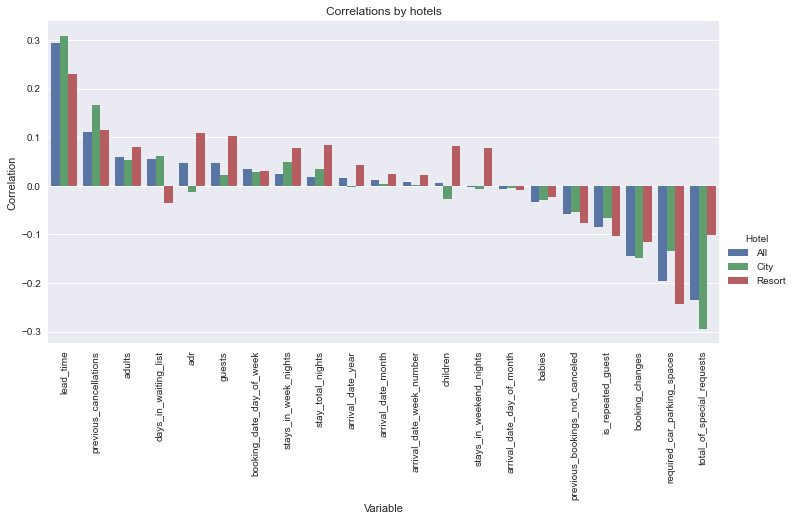

In [140]:
correlations_plot_df = pd.melt(correlations_df.drop('is_canceled'), ignore_index=False, var_name="Hotel", value_name="Correlation")
correlations_plot_df['Variable'] = correlations_plot_df.index
sns.catplot(data=correlations_plot_df, kind='bar', x='Variable', y='Correlation', hue='Hotel', aspect=2)
plt.xticks(rotation=90)
plt.title('Correlations by hotels')
plt.show()

This bar-chart shows that lead_time, previous_canellations, total_of_special_requests, required_car_parking_space and booking_changes have a correlation that is higher than 0.1 (in absolute terms). These are important candidates for our ML model later on. Additionally, the chart shows that for some features the correlation heavily depends on the kind of hotel we are looking at: For example, the number of total special requests is highly correlated with the cancellations at the city hotel, but not so much at the resort hotel. 

Based on this observation we will try out when building our first models, wether separate models or a joint model for both hotels performs better. 

#### 2.1.2 Frequency Distributions

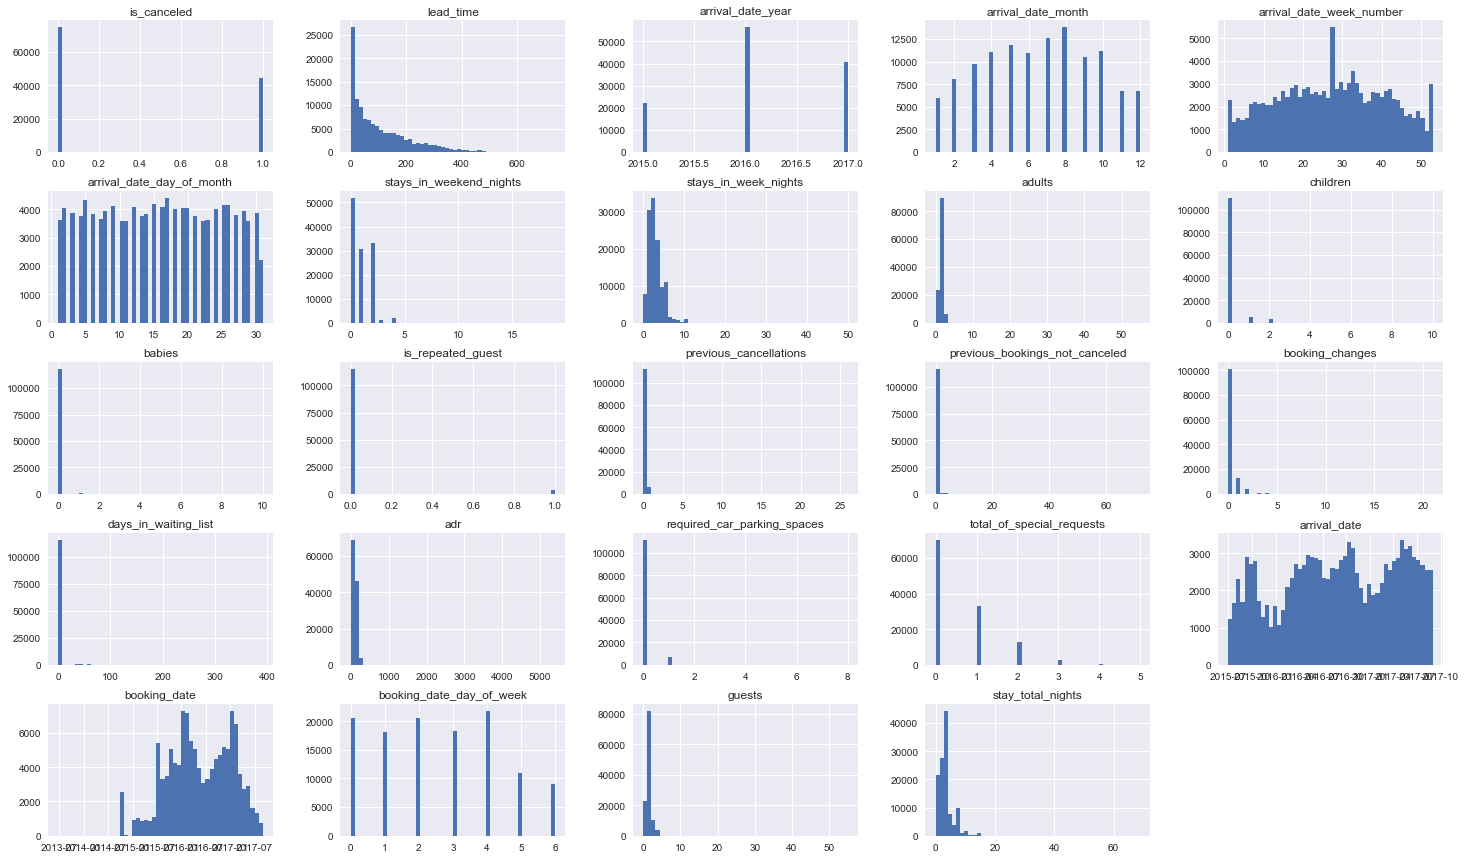

In [136]:
df_num.hist(bins=50, figsize=(25,15))
plt.show()

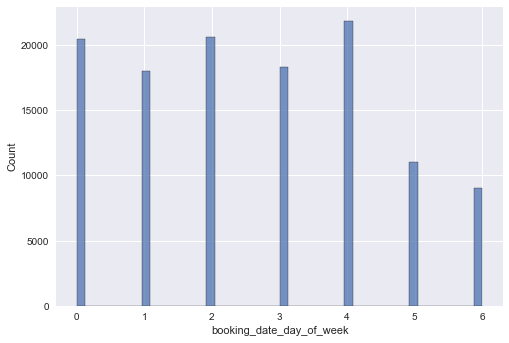

In [137]:
sns.histplot(df['booking_date_day_of_week'])
plt.show(sns)

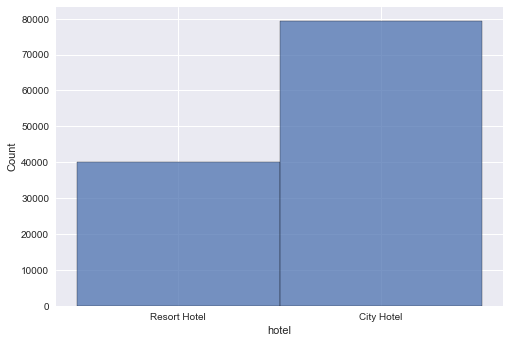

In [138]:
sns.histplot(df['hotel'])
plt.show(sns)

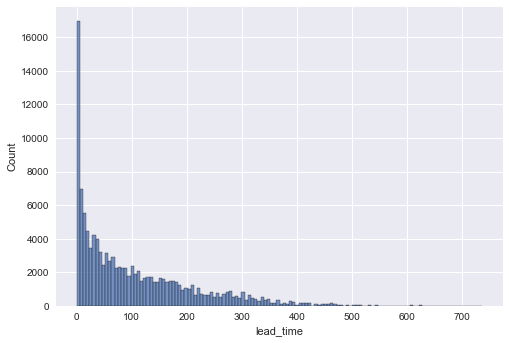

In [139]:
sns.histplot(df['lead_time'])
plt.show(sns)

### 2.2 Categorical variables

#### 2.2.1 Understanding the categories

First we'll create a dataframe with all categorical variables, that are not binary, because we already looked at the binary variables before. 

In [46]:
df_cat = df[['is_canceled', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 
             'assigned_room_type', 'deposit_type', 'agent', 'company', 'customer_type']]

These are quite a lot of categorical variables. Therefore, in the first step of our analysis, we'll only look at the most promising ones. We expect the following variables to be likely to have an impact on the cancellation of a booking.

In [47]:
df_cat_red = df_cat[['is_canceled', 'market_segment', 'distribution_channel', 'deposit_type', 'agent', 
                     'company', 'customer_type' ]]

'Company' and 'agent' are columns with ids. Let's look at the values in the other categorical variables to get a feeling for what they are. 

In [48]:
df_cat_red[['market_segment']].value_counts(normalize = True)

market_segment
Online TA         0.473046
Offline TA/TO     0.202856
Groups            0.165935
Direct            0.105587
Corporate         0.044350
Complementary     0.006223
Aviation          0.001985
Undefined         0.000017
dtype: float64

In [49]:
df_cat_red[['distribution_channel']].value_counts(normalize = True)

distribution_channel
TA/TO                   0.819750
Direct                  0.122665
Corporate               0.055926
GDS                     0.001617
Undefined               0.000042
dtype: float64

In [50]:
df_cat_red[['deposit_type']].value_counts(normalize = True)

deposit_type
No Deposit      0.876464
Non Refund      0.122179
Refundable      0.001357
dtype: float64

In [51]:
df_cat_red[['customer_type']].value_counts(normalize = True)

customer_type  
Transient          0.750591
Transient-Party    0.210436
Contract           0.034140
Group              0.004833
dtype: float64

Especially, the deposit type seems likely to have a high explanatory power. If you have made no deposit you are much more likely to cancel a booking than when you made a non-refundable deposit, right?

#### 2.2.2 Correlations of categorical variables with cancellations

Let's OneHot Encode the categories and IDs (for agent and company) in the next step and get their correlations with the cancellations. 

In [75]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(sparse = False)
df_cat_red_trans = pd.DataFrame(onehot.fit_transform(df_cat_red.drop(columns = 'is_canceled')),
                                columns = onehot.get_feature_names())

In [76]:
df_cat_red_trans = pd.concat([df_cat_red.is_canceled, df_cat_red_trans], axis = 1 )


,is_canceled,x0_Aviation,x0_Complementary,x0_Corporate,x0_Direct,x0_Groups,x0_Offline TA/TO,x0_Online TA,x0_Undefined,x1_Corporate,...,x4_531.0,x4_534.0,x4_539.0,x4_541.0,x4_543.0,x4_nan,x5_Contract,x5_Group,x5_Transient,x5_Transient-Party
0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
119386,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
119387,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
119388,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Now we'll use this transformed dataframe of our categorical variables and find out how correlated they are with 'is_canceled'.

Watch out, the next cell takes quite a while to compute. 

In [84]:
df_cat_corr = df_cat_red_trans.corr()
df_cat_corr = df_cat_corr['is_canceled']

This is gives a dataframe of 708 correlations with the label. Very likely, most of them will have a very low correlation with the label. Therefore, let's only look at the ones with a correlation of more than 0.05 (positive or negative).

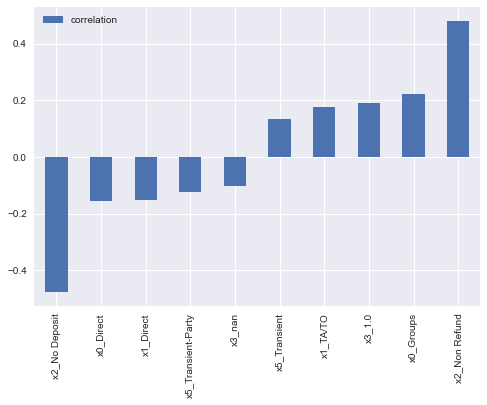

In [122]:
df_cat_corr_red = pd.DataFrame(df_cat_corr).rename({'is_canceled' : 'correlation'}, axis = 1)
df_cat_corr_red = df_cat_corr_red[(df_cat_corr_red['correlation'] >= 0.1 ) | (df_cat_corr_red['correlation'] <= -0.1) ]
df_cat_corr_red.sort_values(by = 'correlation')[:-1].plot(kind = 'bar')
plt.show()

This gives us a good indication, that especially x2 (= 'deposit_type') is likely to have a high explanatory power. But also x0 (= 'market_segment'), one value form the x3 (= 'agent') feature and x1 (= 'distribution_channel') can be important when building the model.